In [684]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

In [685]:
device = torch.device("cuda") 

In [686]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(1)
np.random.seed(31415)

In [687]:
import pandas as pd
df = pd.read_csv('/content/train_data.csv', delimiter=",")
test = pd.read_csv('/content/test_data.csv', delimiter=",")
df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [688]:
def changePeriodsColToMean(df):
  new = pd.DataFrame()
  new[['TimeToBusStopF','TimeToBusStopE']] = df['TimeToBusStop'].str.replace('min', '').str.split('~',expand=True)
  df['TimeToBusStop'] = (new['TimeToBusStopF'].astype(float) + new['TimeToBusStopE'].astype(float)) / 2
  new[['TimeToSubwayF','TimeToSubwayE']] = df['TimeToSubway'].str.replace('min', '')\
  .str.replace('-', '~').str.replace('no_bus_stop_nearby', '20~20').str.split('~',expand=True)
  df['TimeToSubway'] = (new['TimeToSubwayF'].astype(float) + new['TimeToSubwayE'].astype(float)) / 2
  return df

In [689]:
df = changePeriodsColToMean(df)
test = changePeriodsColToMean(test)

In [690]:
train=df.sample(frac=0.8,random_state=200)
val=df.drop(train.index)

In [691]:
cont_cols = ["YearBuilt", "Size(sqf)", "Floor", "N_Parkinglot(Ground)",\
             "N_Parkinglot(Basement)", "TimeToBusStop", "TimeToSubway",\
             "N_manager", "N_elevators", "N_FacilitiesInApt",\
             "N_FacilitiesNearBy(Total)", "N_SchoolNearBy(Total)"]
             
cat_cols = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]

In [692]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [693]:
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)
scaled_columns  = scaler.fit_transform(train[cont_cols]) 
encoded_columns = ohe.fit_transform(train[cat_cols])
processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)

scaled_columns_val  = scaler.transform(val[cont_cols]) 
encoded_columns_val = ohe.transform(val[cat_cols])
processed_data_val = np.concatenate([scaled_columns_val, encoded_columns_val], axis=1)

scaled_columns_test  = scaler.transform(test[cont_cols]) 
encoded_columns_test = ohe.transform(test[cat_cols])
processed_data_test = np.concatenate([scaled_columns_test, encoded_columns_test], axis=1)

In [694]:
processed_data[0]

array([ 1.26359555, -0.11469587,  0.40356448, -0.48825664,  1.49064319,
       -0.54157441, -0.88720075,  0.22572937,  1.16115186,  1.38668924,
        1.19818537,  1.37578284,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ])

In [695]:
def classifyPrices(prices):
  pricesTen = torch.from_numpy(prices).float().to(device)
  return torch.where(pricesTen <= 1e5, torch.tensor(0.).to(device),\
                      torch.where(pricesTen <= 3.5e5, torch.tensor(1.).to(device),\
                                  torch.tensor(2.).to(device)))

In [696]:
pricesTrain = classifyPrices(train.values[:,0].astype(float)).float()
pricesVal = classifyPrices(val.values[:,0].astype(float)).float()
pricesTrain

tensor([2., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')

In [697]:
train_dataset = data.TensorDataset(torch.from_numpy(processed_data).float(), pricesTrain)
val_dataset = data.TensorDataset(torch.from_numpy(processed_data_val).float(), pricesVal)

In [698]:
print(processed_data.shape)
print(processed_data_val.shape)

(3299, 27)
(825, 27)


In [699]:
batch_size=512
train_data_loader  = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [700]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.lin1 = nn.Linear(27, 64) 
        self.bn1 =  nn.BatchNorm1d(64)
        self.d1 = nn.Dropout(0.5)
        self.act1 = nn.ReLU()
        
        self.lin2 = nn.Linear(64, 48)
        self.bn2 =  nn.BatchNorm1d(48)
        self.d2 = nn.Dropout(0.5)
        self.act2 = nn.ReLU()

        self.lin3 = nn.Linear(48, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.d3 = nn.Dropout(0.5)
        self.act3 = nn.ReLU()

        self.lin4 = nn.Linear(32,32)
        self.bn4 = nn.BatchNorm1d(32)
        self.d4 = nn.Dropout(0.5)
        self.act4 = nn.ReLU()

        self.lin5 = nn.Linear(32,3)
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.d1(x)

        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.d2(x)

        x = self.lin3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.d3(x)

        x = self.lin4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.d4(x)

        x = self.lin5(x)
        return x

In [701]:
model = MyNetBN()
model.to(device)
print(model)

MyNetBN(
  (lin1): Linear(in_features=27, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.5, inplace=False)
  (act1): ReLU()
  (lin2): Linear(in_features=64, out_features=48, bias=True)
  (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout(p=0.5, inplace=False)
  (act2): ReLU()
  (lin3): Linear(in_features=48, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.5, inplace=False)
  (act3): ReLU()
  (lin4): Linear(in_features=32, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.5, inplace=False)
  (act4): ReLU()
  (lin5): Linear(in_features=32, out_features=3, bias=True)
)


In [702]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [703]:
criterion = nn.CrossEntropyLoss()

In [704]:
def get_accuracy(model, data):
    correct = [0, 0, 0]
    total = [0, 0, 0]
    model.eval()
    with torch.no_grad():
      for inputs, labels in torch.utils.data.DataLoader(data, batch_size=256):
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs).squeeze()
          pred = outputs.max(1, keepdim=True)[1] # get the index of the max logit
          for i in range(3):
            correct[i] += pred[labels == i].eq(labels[labels == i].view_as(pred[labels == i])).sum().item()
            total[i] += len(pred[labels == i])
      acc = [correct[i]/total[i] for i in range(3)]
      return [ sum(acc)/len(acc), acc]

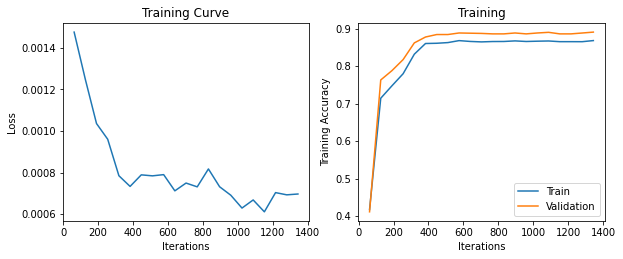

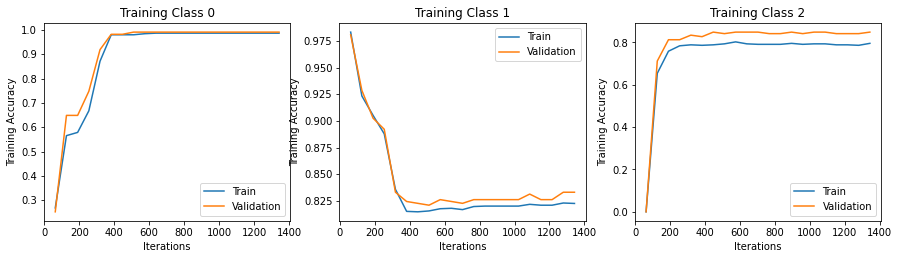

Final Training Accuracy: 0.8683423789575261
Final Validation Accuracy: 0.8909851108537378


In [705]:
# Training loop
iters, losses, train_acc_mean, val_acc_mean = [], [], [], []
train_acc, val_acc = [[], [], []], [[], [], []]
idx = 0
for epoch in range(200): 
  for inputs, labels in train_data_loader:
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)
    model.train()
    outputs = model(inputs)
    
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if idx % 64 == 63:
      iters.append(idx)
      losses.append(float(loss)/batch_size)
      tr_acc = get_accuracy(model, train_dataset);
      va_acc = get_accuracy(model, val_dataset);
      for i in range(3):
        train_acc[i].append(tr_acc[1][i])
        val_acc[i].append(va_acc[1][i])
      train_acc_mean.append(tr_acc[0])
      val_acc_mean.append(va_acc[0])
    idx+=1

# plotting
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(2,3,2)
plt.title("Training")
plt.plot(iters, train_acc_mean, label="Train")
plt.plot(iters, val_acc_mean, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,3,4)
plt.title("Training Class 0")
plt.plot(iters, train_acc[0], label="Train")
plt.plot(iters, val_acc[0], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')

plt.subplot(2,3,5)
plt.title("Training Class 1")
plt.plot(iters, train_acc[1], label="Train")
plt.plot(iters, val_acc[1], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')

plt.subplot(2,3,6)
plt.title("Training Class 2")
plt.plot(iters, train_acc[2], label="Train")
plt.plot(iters, val_acc[2], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc_mean[-1]))
print("Final Validation Accuracy: {}".format(val_acc_mean[-1]))

In [706]:
print(get_accuracy(model, train_dataset)) # compute training accuracy 
print(get_accuracy(model, val_dataset))

[0.8684802909696624, [0.9866962305986696, 0.822920976417046, 0.7958236658932715]]
[0.8915648209986653, [0.990990990990991, 0.8347826086956521, 0.8489208633093526]]


Text(0.5, 1.0, 'Labels')

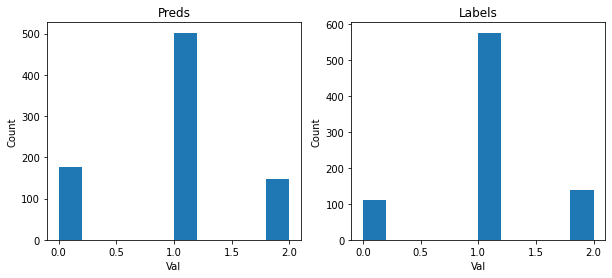

In [707]:
model.eval()
preds = []
labelsList = []
with torch.no_grad():
      for inputs, labels in torch.utils.data.DataLoader(val_dataset, batch_size=256):
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs).squeeze()
          labelsList += labels.cpu().tolist()
          preds += outputs.max(1)[1].cpu().tolist() # get the index of the max logit
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(preds)
plt.xlabel("Val")
plt.ylabel("Count")
plt.title("Preds")
plt.subplot(1,2,2)
plt.hist(labelsList)
plt.xlabel("Val")
plt.ylabel("Count")
plt.title("Labels")

Text(0.5, 1.0, 'Preds')

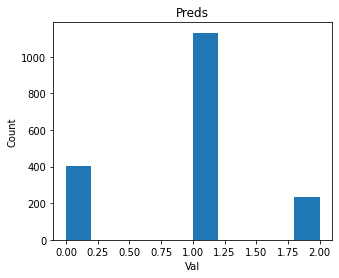

In [708]:
test_dataset = data.TensorDataset(torch.from_numpy(processed_data_test).float(),torch.ones_like(torch.from_numpy(processed_data_test[:,0])))
model.eval()
preds = []
with torch.no_grad():
      for inputs, labels in data.DataLoader(test_dataset, batch_size=256, shuffle=False):
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs).squeeze()
          preds += outputs.max(1)[1].cpu().tolist() # get the index of the max logit
plt.figure(figsize=(5,4))
plt.hist(preds)
plt.xlabel("Val")
plt.ylabel("Count")
plt.title("Preds")

In [709]:
preds = pd.DataFrame(np.array(preds))
preds.to_csv("Bielak_Nitkiewicz.csv",index=False, header=None) #save to file

#Then, to reload:
df = pd.read_csv("Bielak_Nitkiewicz.csv", header=None)
df

,0
0,1
1,1
2,2
3,1
4,1
...,...
1762,2
1763,1
1764,0
1765,1
